In [2]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np

from scipy.stats import multivariate_normal
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

from scipy.stats import gamma
from scipy.special import erfcinv


import git, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [3]:
#Fixed Parameters
#num_parameters = 2
#num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [4]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_K(vectors):
    num_vectors = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    K = np.array([[K_xx, K_xy], [K_yx, K_yy]])
    return K


def construct_C(vectors):
    L = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/(L-1)
    #C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C


'''
def compute_inertia_tensor_cm(positions, masses):
    """
    Compute the inertia tensor relative to the center of mass (CM).
    
    Parameters:
    positions : np.ndarray
        Array of shape (N, 3) containing the positions of N particles.
    masses : np.ndarray
        Array of shape (N,) containing the masses of the N particles.
    
    Returns:
    I_cm : np.ndarray
        The 3x3 inertia tensor relative to the center of mass.
    """
    # Compute the total mass
    M = np.sum(masses)
    
    # Compute the center of mass
    R_cm = np.sum(masses[:, np.newaxis] * positions, axis=0) / M
    
    # Compute the positions relative to the center of mass
    rel_positions = positions - R_cm
    
    # Initialize the inertia tensor
    I_cm = np.zeros((2, 2))
    
    # Compute the inertia tensor relative to CM
    for i in range(len(masses)):
        m = masses[i]
        x, y = rel_positions[i]
        
        I_cm[0, 0] += m * (y**2)
        I_cm[1, 1] += m * (x**2)
        
        I_cm[0, 1] -= m * x * y
    
    # Exploit symmetry: I_ji = I_ij
    I_cm[1, 0] = I_cm[0, 1]
    
    return I_cm
'''

'\ndef compute_inertia_tensor_cm(positions, masses):\n    """\n    Compute the inertia tensor relative to the center of mass (CM).\n    \n    Parameters:\n    positions : np.ndarray\n        Array of shape (N, 3) containing the positions of N particles.\n    masses : np.ndarray\n        Array of shape (N,) containing the masses of the N particles.\n    \n    Returns:\n    I_cm : np.ndarray\n        The 3x3 inertia tensor relative to the center of mass.\n    """\n    # Compute the total mass\n    M = np.sum(masses)\n    \n    # Compute the center of mass\n    R_cm = np.sum(masses[:, np.newaxis] * positions, axis=0) / M\n    \n    # Compute the positions relative to the center of mass\n    rel_positions = positions - R_cm\n    \n    # Initialize the inertia tensor\n    I_cm = np.zeros((2, 2))\n    \n    # Compute the inertia tensor relative to CM\n    for i in range(len(masses)):\n        m = masses[i]\n        x, y = rel_positions[i]\n        \n        I_cm[0, 0] += m * (y**2)\n        


For conviencience we will name the pairs as:

* 1: AB
* 2: AC
* 3: BC

## Tension vectors
$$\vec{r}_{1}=\frac{1}{\sqrt{C_{A}+C_{B}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{B}) $$
$$\vec{r}_{2}=\frac{1}{\sqrt{C_{A}+C_{C}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{C}) $$
$$\vec{r}_{3}=\frac{1}{\sqrt{C_{B}+C_{C}}}(\vec{\bar{\theta}}_{B}-\vec{\bar{\theta}}_{C}) $$

In general, if we have N datasets, the total number tension vectors is 

$$L=\frac{N^2-N}{2}=\frac{N(N-1)}{2}$$

## Center of Mass

$$\vec{R}_{CM} = \frac{\sum_i m_{i} \vec{r}_{i}}{\sum_i m_{i}} \, ,$$

where $m_{i}=1$.

## Mass Dispertion Tensor

$$K_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} (\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})$$

$$\mathcal{C}_{ij} = \frac{K_{ij}}{\sum_i m_{i}} \, ,$$

## Inertia Tensor

$$I_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} [\delta_{ij}|\vec{r}_{k}-\vec{R}_{CM}|^{2}-(\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})]$$



In [5]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
K = construct_K(vectors)
print('Tensor of Inertia: {}'.format(K))

#I = compute_inertia_tensor_cm(vectors, np.ones(3))
#print('Tensor of Inertia: {}'.format(I))

eigenvalues, eigenvectors = np.linalg.eigh(K)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))
print('The volume of the ellipsoid is given by the square root of the determinant of K: {}'.format(np.sqrt(np.linalg.det(K))))

Center of mass: [-0.23570226 -0.40824829]
Tensor of Inertia: [[ 0.58333333 -0.28867513]
 [-0.28867513  0.25      ]]
Eigenvalues: [0.08333333 0.75      ]
Eigenvectors: [[-0.5       -0.8660254]
 [-0.8660254  0.5      ]]
The volume of the ellipsoid is given by the square root of the determinant of K: 0.25


Plot this information:

# Real data

In [6]:
import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))

os.chdir(os.path.join(path_global,'montepython_public_old','output'))   
#os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples .loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters
names = param_names
labels = names

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)


In [7]:
os.path.join(path_git, 'notebooks','PRL', 'figures')
print(path_git)

/home/matias/Documents/PhD/code/multimeter


In [34]:
#In terms of P (montecarlo integration)
d=2
L=6

Center of mass: [-1.1227663  -1.84922768]
Tensor of Inertia: [[1.9538412  2.15803215]
 [2.15803215 5.42756901]]
Eigenvalues: [0.92054284 6.46086737]
Eigenvectors: [[-0.90193956 -0.43186227]
 [ 0.43186227 -0.90193956]]


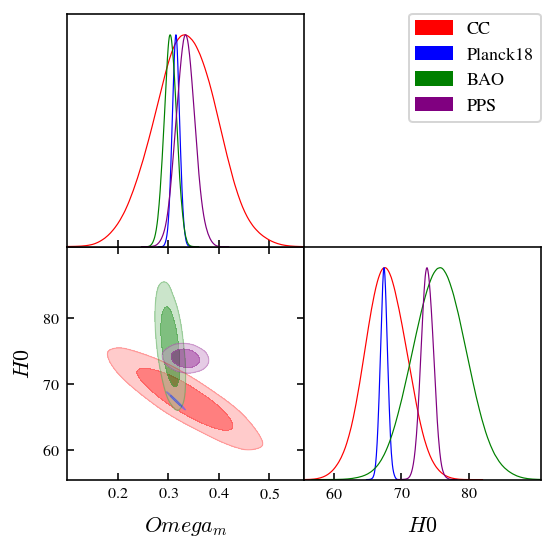

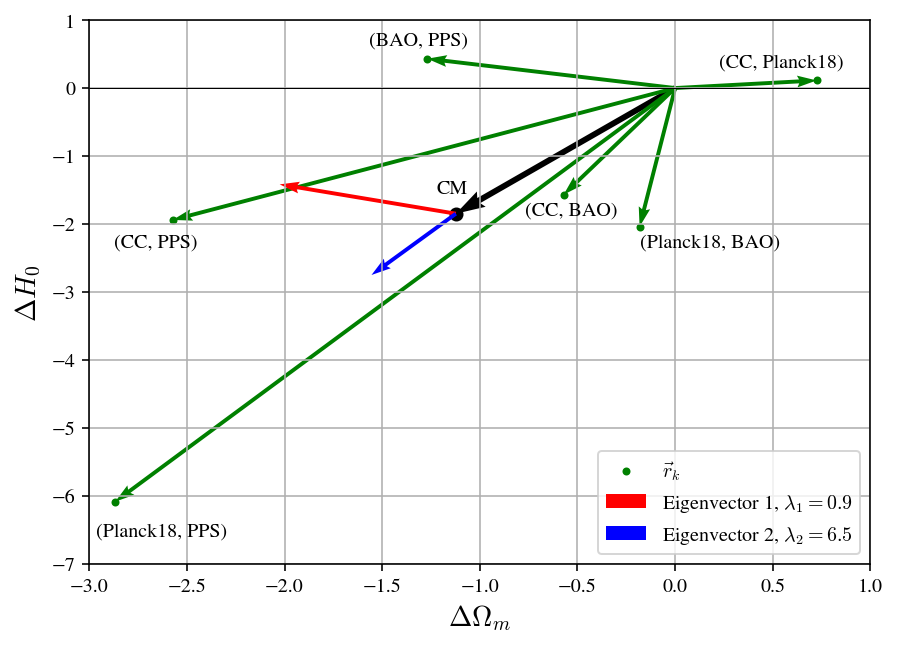

In [9]:
from scipy.stats import multivariate_normal

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))


# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
samps_D = np.random.multivariate_normal(mean_D, cov_D, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm= multivariate_normal(R_CM, C)

#x=np.linspace(-10, 10, 100)
#y=np.linspace(-10, 10, 100)
#x,y = np.meshgrid(x,y)
#os = np.dstack((x, y))
#ax.contourf(x, y, samps_Rcm.pdf(pos),alpha=0.5, cmap='Blues')



#fig, ax = plt.subplots(1,1, figsize=(7,5))
#ax.hist2d(samps_Rcm[:,0], samps_Rcm[:,1], bins=int(np.sqrt(int(1e5))), cmap='Blues', density=True)

#First plot
#axes[0].scatter([(mean_A - mean_B)[0], (mean_A - mean_C)[0], (mean_B - mean_C)[0], (mean_A - mean_D)[0], (mean_B - mean_D)[0], (mean_C - mean_D)[0]],\
#                [(mean_A - mean_B)[1], (mean_A - mean_C)[1], (mean_B - mean_C)[1], (mean_A - mean_D)[1], (mean_B - mean_D)[1], (mean_C - mean_D)[1]],\
#                 color='red', label=r'$(\theta_{i} - \theta_{j})$')
ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)

ax.scatter([r_1[0], r_2[0], r_3[0], r_4[0], r_5[0], r_6[0]], [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.text(R_CM[0]-0.1, R_CM[1]+0.3, 'CM')
ax.text(r_1[0]-0.5, r_1[1]+0.2, '(CC, Planck18)', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, '(CC, BAO)')
ax.text(r_3[0]-0.0, r_3[1]-0.3, '(Planck18, BAO)')
ax.text(r_4[0]-0.3, r_4[1]-0.4, '(CC, PPS)')
ax.text(r_5[0]-0.1, r_5[1]-0.5, '(Planck18, PPS)')
ax.text(r_6[0]-0.3, r_6[1]+0.2, '(BAO, PPS)')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))
#x_min, x_max = (R_CM[0] + eigenvectors[0, :]).min()-1, (R_CM[0] + eigenvectors[0, :]).max()+1
#y_min, y_max = (R_CM[1] + eigenvectors[1, :]).min()-1, (R_CM[1] + eigenvectors[1, :]).max()+1
#axes[1].set_xlim(1.1 * x_min, 1.1 * x_max)
#axes[1].set_ylim(1.1 * y_min, 1.1 * y_max)

ax.set_xlim(-3, 1)
ax.set_ylim(-7, 1)
ax.set_xlabel(r'$\Delta \Omega_m$',size=14)

#ax.vlines(0, -7, 1, color='black', lw=0.5)
ax.hlines(0, -3, 1, color='black', lw=0.5)
ax.set_ylabel(r'$\Delta H_0$',size=14)
ax.grid()
ax.legend(loc='lower right')
#plt.grid()
#plt.xlabel(r'$\Delta \Omega_m$',size=14)
#plt.ylabel(r'$\Delta H_0$',size=14)





'''
A: CC 
B: Planck18 
C: BAO 
D: PPS

1:AB
2:AC
3:BC
4:AD
5:BD
6:CD
'''

#ax.legend(loc='lower left')
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

#plt.text()

Center of mass: [-1.1227663  -1.84922768]
Tensor of Inertia: [[1.9538412  2.15803215]
 [2.15803215 5.42756901]]
Eigenvalues: [0.92054284 6.46086737]
Eigenvectors: [[-0.90193956  0.43186227]
 [ 0.43186227  0.90193956]]


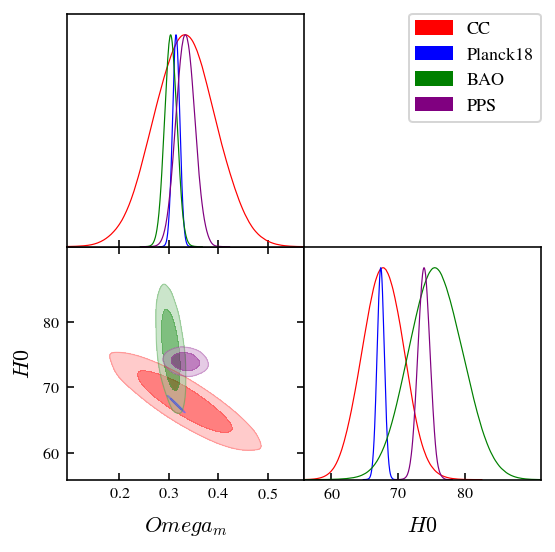

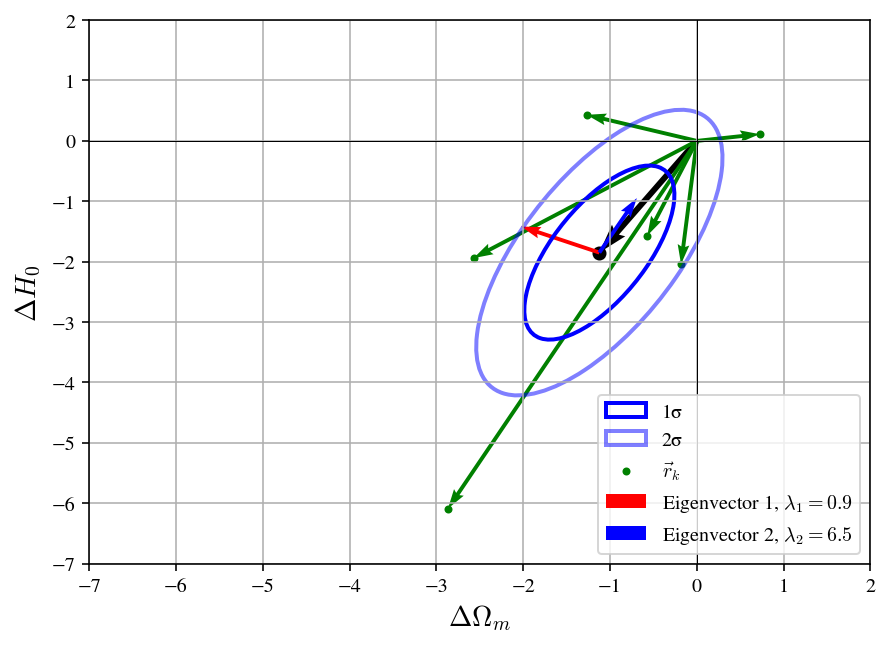

In [10]:
from scipy.stats import multivariate_normal

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))


# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eigh(C)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
samps_D = np.random.multivariate_normal(mean_D, cov_D, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm= multivariate_normal(R_CM, C)

#x=np.linspace(-10, 10, 100)
#y=np.linspace(-10, 10, 100)
#x,y = np.meshgrid(x,y)
#pos = np.dstack((x, y))
#ax.contourf(x, y, samps_Rcm.pdf(pos),alpha=0.5, cmap='Blues')


# Define mean and covariance
mean = R_CM
cov = C/L

# Compute eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov)

# Compute the angle between the x-axis and the largest eigenvector
angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))

# 1-sigma and 2-sigma contour radii (sqrt of chi2 quantiles for 2D Gaussian)
chi2_1sigma = 2.295  # 1-sigma corresponds to ~39.3% region in 2D
chi2_2sigma = 6.180  # 2-sigma corresponds to ~86.5% region in 2D
height_1sigma, width_1sigma = 2 * np.sqrt(eigvals * chi2_1sigma)
height_2sigma, width_2sigma = 2 * np.sqrt(eigvals * chi2_2sigma)

#BEFORE
#width_1sigma, height_1sigma = 2 * np.sqrt(eigvals * chi2_1sigma)
#width_2sigma, height_1sigma = 2 * np.sqrt(eigvals * chi2_2sigma)



# Draw the 1-sigma and 2-sigma ellipses
ellipse_1sigma = Ellipse(xy=mean, width=width_1sigma, height=height_1sigma,
                         angle=angle, edgecolor='blue', fc='None', lw=2, label='1σ')
ellipse_2sigma = Ellipse(xy=mean, width=width_2sigma, height=height_2sigma,
                         angle=angle, edgecolor='blue', fc='None', lw=2, label='2σ',alpha=0.5)

ax.add_patch(ellipse_1sigma)
ax.add_patch(ellipse_2sigma)

ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)

ax.scatter([r_1[0], r_2[0], r_3[0], r_4[0], r_5[0], r_6[0]], [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

#ax.text(R_CM[0]-0.1, R_CM[1]+0.3, 'CM')
#ax.text(r_1[0]-0.5, r_1[1]+0.2, '(CC, Planck18)', size=10)
#ax.text(r_2[0]-0.2, r_2[1]-0.3, '(CC, BAO)')
#ax.text(r_3[0]-0.0, r_3[1]-0.3, '(Planck18, BAO)')
#ax.text(r_4[0]-0.3, r_4[1]-0.4, '(CC, PPS)')
#ax.text(r_5[0]-0.1, r_5[1]-0.5, '(Planck18, PPS)')
#ax.text(r_6[0]-0.3, r_6[1]+0.2, '(BAO, PPS)')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.set_xlim(-7, 2)
ax.set_ylim(-7, 2)

ax.set_xlabel(r'$\Delta \Omega_m$',size=14)

ax.vlines(0, -10, 5, color='black', lw=0.5)
ax.hlines(0, -10, 5, color='black', lw=0.5)
ax.set_ylabel(r'$\Delta H_0$',size=14)
ax.grid()
ax.legend(loc='lower right')
#plt.grid()
#plt.xlabel(r'$\Delta \Omega_m$',size=14)
#plt.ylabel(r'$\Delta H_0$',size=14)





'''
A: CC 
B: Planck18 
C: BAO 
D: PPS

1:AB
2:AC
3:BC
4:AD
5:BD
6:CD
'''

#ax.legend(loc='lower left')
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

#plt.text()

In [ ]:
eigvals, eigvecs = np.linalg.eigh(cov) #C/L

print('Eigenvalues: {}'.format(eigvals))
print('Eigenvectors: {}'.format(eigvecs))


Eigenvalues: [0.15342381 1.07681123]
Eigenvectors: [[-0.90193956  0.43186227]
 [ 0.43186227  0.90193956]]


In [12]:
eigenvalues, eigenvectors = np.linalg.eigh(C)
print('Ratio of eigenvalues: {:.3f}'.format(min(eigenvalues)/max(eigenvalues)))
print('Determinant: {:.3f}'.format(np.prod(eigenvalues)))
print(eigenvalues)
print(eigenvectors)

print('rho_2: {:.3f}'.format(np.sum(eigenvalues)/np.linalg.norm(R_CM)**2))


Ratio of eigenvalues: 0.142
Determinant: 5.948
[0.92054284 6.46086737]
[[-0.90193956  0.43186227]
 [ 0.43186227  0.90193956]]
rho_2: 1.577


In [13]:
PTE= gamma.sf(np.linalg.norm(R_CM)**2, a=d/2, scale=2/L)
n_sigma = np.sqrt(2) * erfcinv(PTE)
print('P: {}'.format(PTE))
print('n_sigma: {:.3f}'.format(n_sigma))

P: 7.9833178583884e-07
n_sigma: 4.936


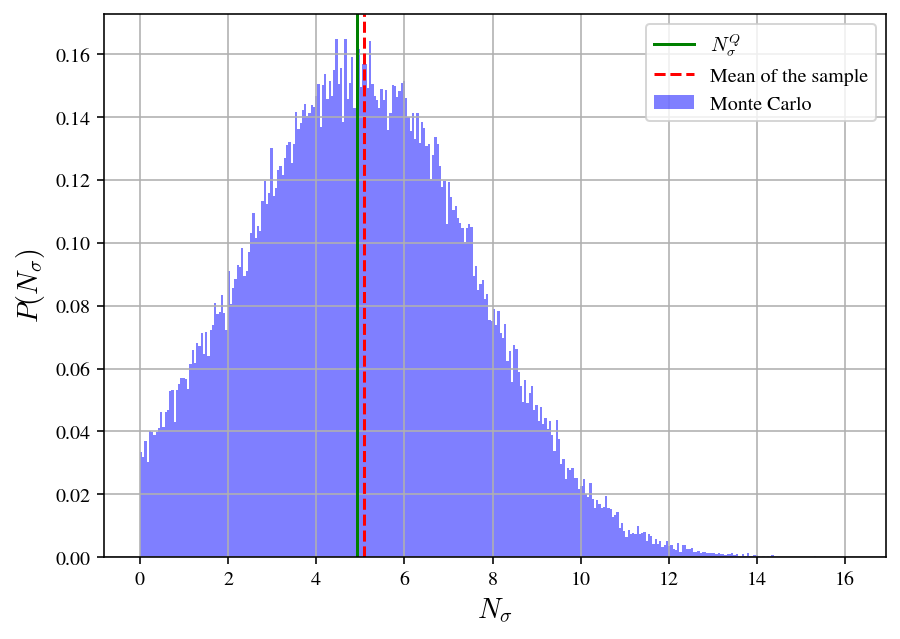

In [78]:
num_samples = int(1e5)
N_Sigmas = np.zeros(num_samples)
norms = np.linalg.norm(np.random.multivariate_normal(R_CM, C/L, size=num_samples),axis=1)

for i in range(len(N_Sigmas)):
    PTE = gamma.sf(norms[i]**2, a=d/2, scale=2/L)
    N_Sigmas[i] = np.sqrt(2) * erfcinv(PTE)

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.hist(N_Sigmas, bins=int(np.sqrt(num_samples)), density=True, alpha=0.5, color='blue', label='Monte Carlo')
ax.axvline(n_sigma, color='green', linestyle='-', label=r'$N_\sigma^{Q}$')
ax.axvline(np.mean(N_Sigmas), color='red', linestyle='--', label='Mean of the sample')

ax.set_xlabel(r'$N_\sigma$',size=14)
ax.set_ylabel(r'$P(N_\sigma)$',size=14)
ax.legend()
ax.grid()
fig.savefig('montecarlo.pdf', dpi=300, bbox_inches='tight')



In [79]:
print('Mean: {:.3g}'.format(np.mean(N_Sigmas)))
print('Std: {:.3g}'.format(np.std(N_Sigmas)))

print('Median: {:.3g}'.format(np.median(N_Sigmas)))
lower_bound = np.percentile(N_Sigmas, 68.3)
print('1-sigma lower bound: {:.3g}'.format(lower_bound))
lower_2sigma_bound = np.percentile(N_Sigmas, 95)
print('2-sigma lower bound: {:.3g}'.format(lower_2sigma_bound))

Mean: 5.08
Std: 2.46
Median: 5.01
1-sigma lower bound: 6.25
2-sigma lower bound: 9.25


Estimemos el sesgo estimado el $|R_{CM}|^2$ usando $\mathcal{Q}$

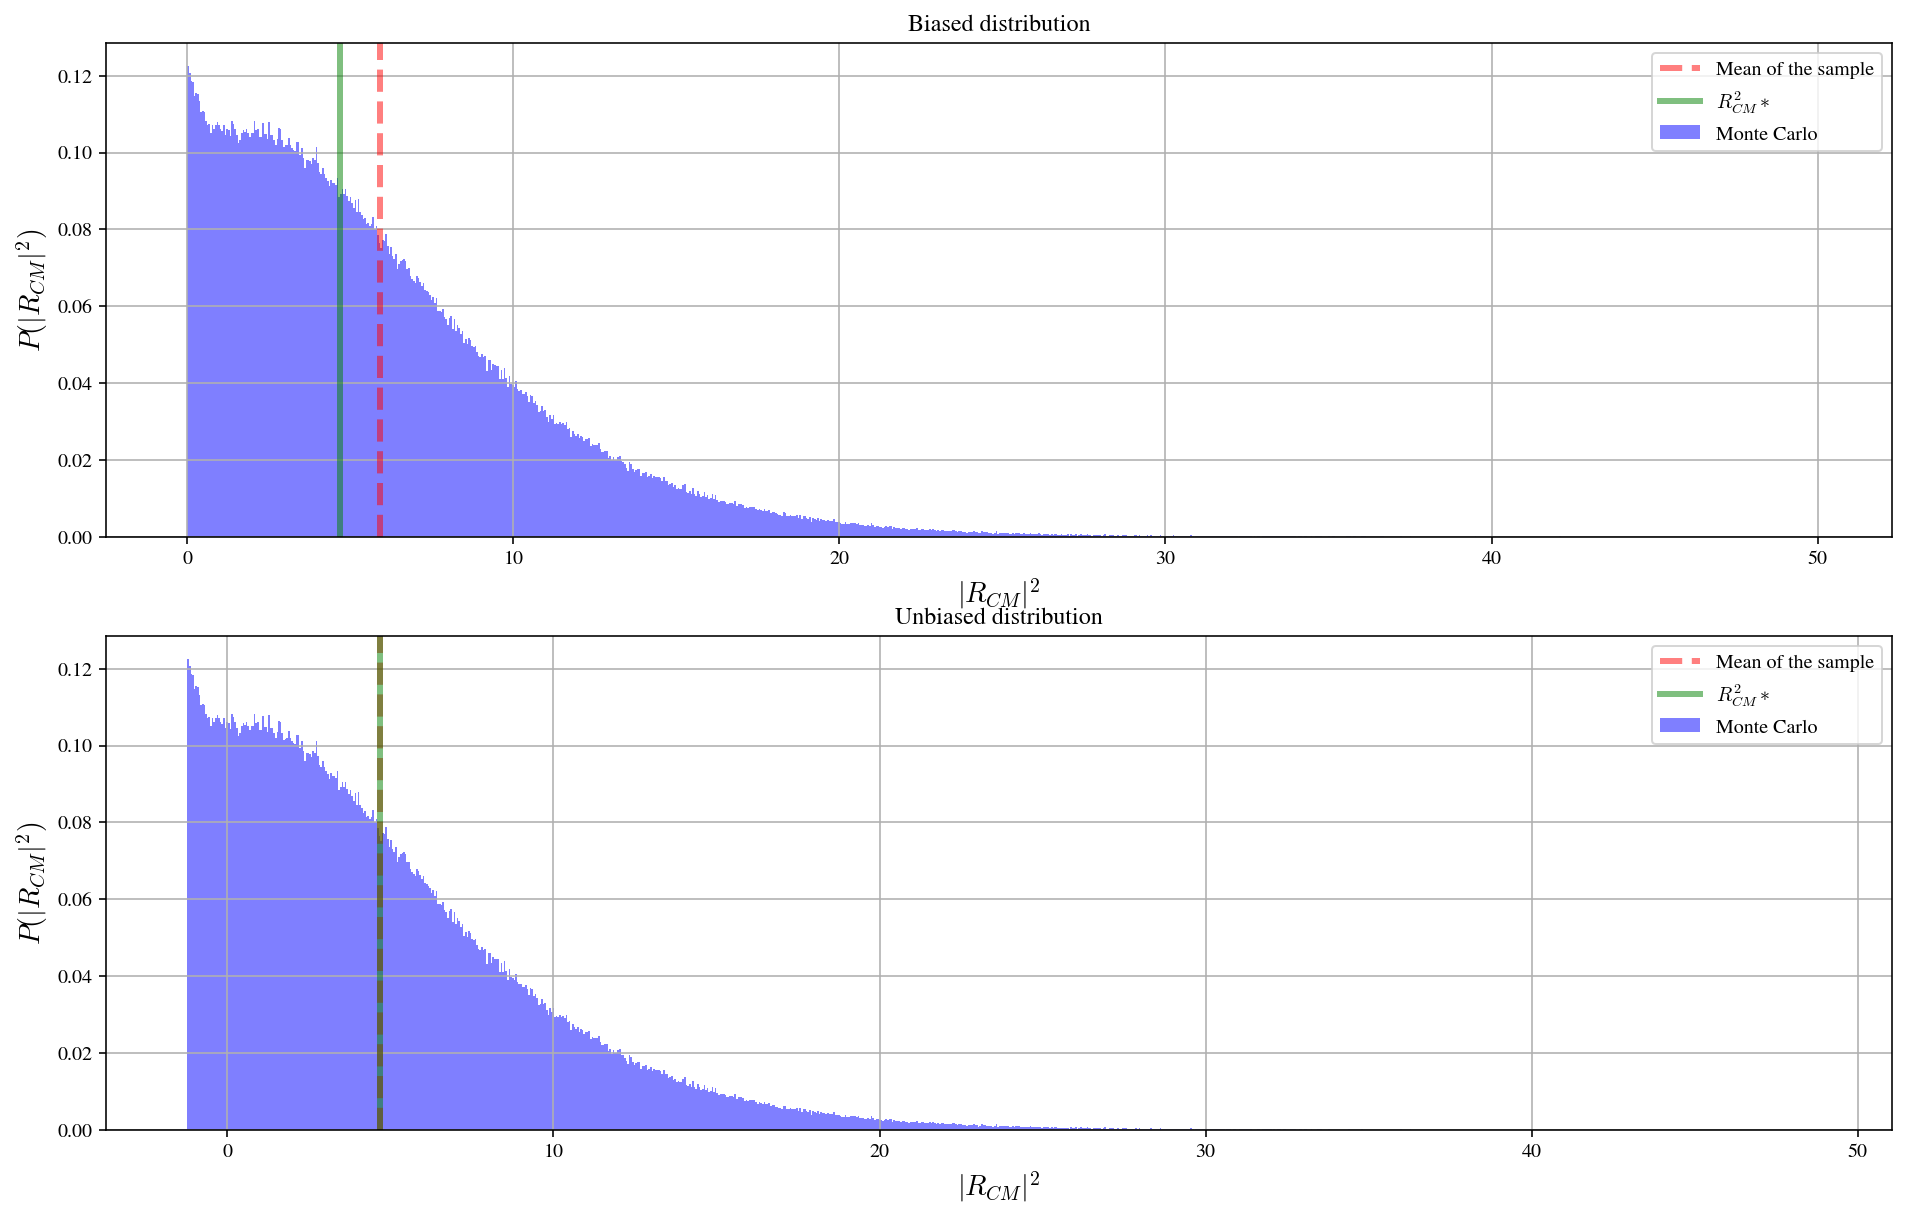

In [115]:
num_samples = int(1e6)
norms = np.linalg.norm(np.random.multivariate_normal(R_CM, C/L, size=num_samples),axis=1)
bias = - np.sum(eigenvalues)/L

fig, axes = plt.subplots(2,1, figsize=(16,10))
axes[0].set_title('Biased distribution')
axes[0].hist(norms**2, bins=int(np.sqrt(num_samples)), density=True, alpha=0.5, color='blue', label='Monte Carlo')
axes[0].axvline(np.mean(norms**2), color='red', linestyle='--', label='Mean of the sample',alpha=0.5,lw=3)

axes[1].set_title('Unbiased distribution')
axes[1].hist(norms**2 + bias, bins=int(np.sqrt(num_samples)), density=True, alpha=0.5, color='blue', label='Monte Carlo')
axes[1].axvline(np.mean(norms**2 + bias), color='red', linestyle='--', label='Mean of the sample',alpha=0.5,lw=3)

for ax in axes.flat:
    ax.axvline(np.linalg.norm(R_CM)**2, color='green', linestyle='-', label=r'$R_{CM}^{2}*$',alpha=0.5,lw=3)
    ax.set_xlabel(r'$|R_{CM}|^2$',size=14)
    ax.set_ylabel(r'$P(|R_{CM}|^2)$',size=14)
    ax.legend()
    ax.grid()
fig.savefig('RCM_2_sampling.pdf', dpi=300, bbox_inches='tight')



In [83]:
print('Bias in |Rcm|^2: {}'.format(np.linalg.norm(R_CM)**2-np.mean(norms**2-np.sum(eigenvalues)/L))
)


Bias in |Rcm|^2: 0.0014641960322805403
